In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from pe1_definitions  import *

# needed for ipython to reload local module every run
%load_ext autoreload
%autoreload 1
%aimport pe1_definitions
plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


L2 Error: 0.00365


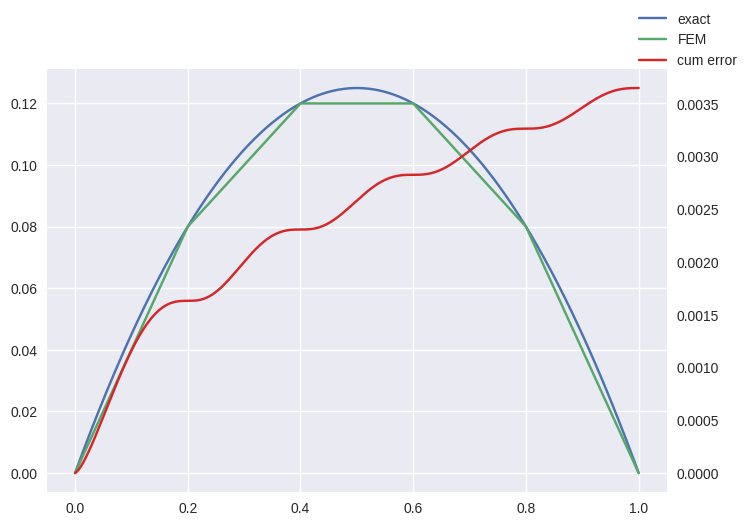

In [7]:
x0, xN = 0, 1
N = 5
h = (xN - x0) / (N)  # N+1 nodes means N intervals

# get analytical solution u, f(x) and coefficients b
u_f, u_fpp, u_b = funcs["f1"]

a = np.array([[a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])
b = np.array([u_b(i, h) for i in range(1, N)])
# b = np.array([b_j(i, h, u_fpp, x0, xN) for i in range(1, N)])
x = np.linalg.solve(a, b)

fig, ax = plt.subplots()

fine_x = np.linspace(x0, xN, num=1000)
u_anal = u_f(fine_x)
ax.plot(fine_x, u_anal, label="exact")

x_grid = np.linspace(x0, xN, num=N + 1)
# for basis = hat functions b = u_N(x_k),
# but we only have N-1 b_k corresponding to u_N(x_1) to x_N(x_(N-1))
# so we pad with zero left and right to get u_N(boundary)=0
u_num_corse = np.pad(x, 1, "constant", constant_values=0)
ax.plot(x_grid, u_num_corse, label="FEM")

# plotting high resolution version of function
u_num_fine = constr_f(x, fine_x, h)
# ax.plot(fine_x, u_num_fine)

# print(a)

error = np.sqrt(
    np.cumsum((u_anal - u_num_fine) ** 2) * (fine_x[1] - fine_x[0])
)  # approximate integral by sum


l2_error = l2_err_func(u_f, u_num_corse, x_grid)
print(f"L2 Error: {l2_error:#.3}")


ax2 = ax.twinx()
ax2.plot(fine_x, error, color="tab:red", label="cum error")
ax2.grid(False)
_ = fig.legend()

  L1 Error = 0.083*N^-2.0
  L2 Error = 0.090*N^-2.0
Linf Error = 0.12*N^-2.0


/home/paulemeister/Code/Python/ProgrammingPDE1/individual_solutions/Paul/pe1_definitions.py:133: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  err, _ = sp.integrate.quad(f, x_vals[0], x_vals[-1])


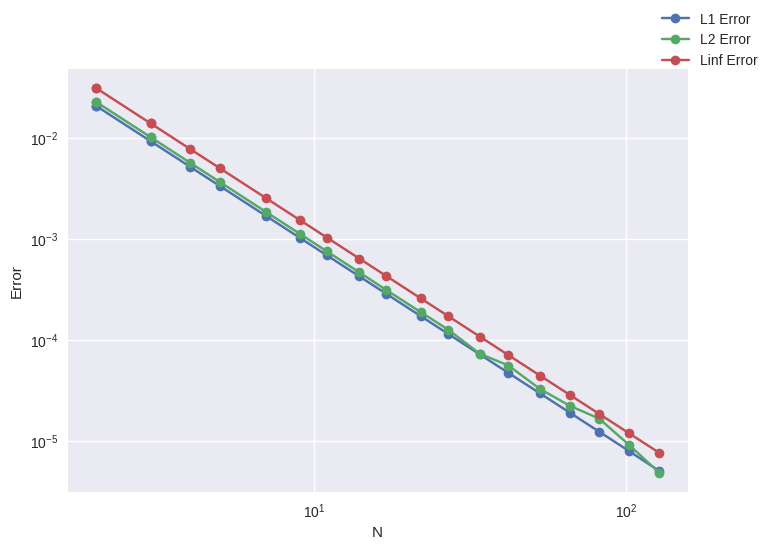

In [5]:
# plot errors over N

u_f, u_fpp, u_b = funcs["f1"]

x0, xN = 0, 1
fine_x = np.linspace(x0, xN, num=10000)

u_anal = u_f(fine_x)

temp1, temp2, temp3 = [], [], []

ns = np.logspace(
    np.log2(3) // 1, np.log2(200) // 1, base=2, dtype=int, num=20
)  # get k integers between a,b evenly spaced in logspace

# ns = np.arange(50, 60)

fig, ax = plt.subplots()

for N in ns:
    print(f"N:{N}", end="\r")  # counter for computation
    h = (xN - x0) / (N)

    a = np.array([[a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])
    b = np.array([u_b(i, h) for i in range(1, N)])
    # b = np.array([b_j(i, h, used_fpp, x0, xN) for i in range(1, N)]) # numerical b
    x = np.linalg.solve(a, b)

    x_grid = np.linspace(x0, xN, num=N + 1)
    u_num_corse = np.pad(x, 1, "constant", constant_values=0)

    temp1.append(l1_err_func(u_f, u_num_corse, x_grid))
    temp2.append(l2_err_func(u_f, u_num_corse, x_grid))
    temp3.append(linf_err_func(u_f, u_num_corse, x_grid))


l1_errors = np.array(temp1)
l2_errors = np.array(temp2)
linf_errors = np.array(temp3)

ax.plot(ns, l1_errors, "-o", label="L1 Error")
ax.plot(ns, l2_errors, "-o", label="L2 Error")
ax.plot(ns, linf_errors, "-o", label="Linf Error")

ax.set_xlabel("N")
ax.set_ylabel("Error")
ax.set_xscale("log")
ax.set_yscale("log")
fig.legend()

for errors, label in zip(
    [l1_errors, l2_errors, linf_errors], ["L1 Error", "L2 Error", "Linf Error"]
):
    # as y = c x^n
    # log(y) = log(c) + n*log(x)
    # so we find the convergence order n by linear regression
    slope, intercept = np.polyfit(np.log(ns), np.log(errors), 1)
    print(f"{label:>10} = {np.exp(intercept):#.2}*N^{slope:#.2}")